<a href="https://colab.research.google.com/github/hong-michael/dynamics-and-simulation/blob/main/2R1P_robot_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4
## hongm
## ME 334: Advanced Dynamics, Control and System Identification
### Stanford University

In [2]:
# imports
import numpy as np
import sympy as sp
from sympy import *
from sympy.vector import *
init_printing(use_unicode=True)


import matplotlib.pyplot as plt  #This is used for static graphs
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3

## Setup

In [3]:
# defining free parameters
th1 = symbols(r'\theta_1')  # variables
th2 = symbols(r'\theta_2')
r3 = symbols(r'r_3')
dth1 = symbols(r'\dot{\theta}_1')  # first derivatives
dth2 = symbols(r'\dot{\theta}_2')
dr3 = symbols(r'\dot{r}_3')
ddth1 = symbols(r'\ddot{\theta}_1')  # second derivatives
ddth2 = symbols(r'\ddot{\theta}_2')
ddr3 = symbols(r'\ddot{r}_3')

In [4]:
## functions for kinematics
def rot_z(theta):
    R = Matrix([
        [sp.cos(theta), -sp.sin(theta), 0],
        [sp.sin(theta), sp.cos(theta), 0],
        [0, 0, 1],
    ])
    return R

def rot_y(theta):
    R = Matrix([
        [sp.cos(theta), 0, sp.sin(theta)],
        [0,1,0],
        [-sp.sin(theta),0, sp.cos(theta)],
    ])
    return R

def rot_x(theta):
    R = Matrix([
        [1, 0, 0],
        [0, sp.cos(theta), -sp.sin(theta)],
        [0, sp.sin(theta), sp.cos(theta)],
    ])
    return R

## Use HW3 code in this section
#### (yours if verified, or solution code when it becomes available)


In [5]:
## frames and joint variables

## [TODO] Define rotations between frames (you can use the above functions)
R_AB = rot_z(th1)
R_BC = rot_x(th2)

In [7]:
## link geometry
########### (WATCH OUT FOR UNITS!) #############

## [TODO] Fill in the data from the problem

## kinematic params
L1 = 0.130  # OQ
L2 = 0.300  # QR

# link 1
H1v = 0.200  # Height of vertical cylinder
R1v = 0.025  # Radius of vertical cylinder
H1h = L2 - R1v  # Height (length) of horizontal cylinder
R1h = 0.0175  # Radius of horizontal cylinder

# link 2
H2 = 0.250
R2i = 0.006
R2e = 0.012

# link 3
H3 = 0.250
R3 = 0.0055

## density of aluminum
rho = 2700

First, we compute the locations of the centers of mass of each link.

In [8]:
def mass_cylinder(R, H, rho):
    return np.pi * R ** 2 * H * rho

m1 = mass_cylinder(R1v, H1v, rho) + mass_cylinder(R1h, H1h, rho)
m2 = mass_cylinder(R2e, H2, rho) - mass_cylinder(R2i, H2, rho)
m3 = mass_cylinder(R3, H3, rho)

m1, m2, m3

(1.774656237581747, 0.2290221044466959, 0.06414739499548658)

In [9]:
# Location of P1 (COM 1)
mv = np.pi * (R1v ** 2) * H1v * rho  # Vertical mass
mh = np.pi * (R1h ** 2) * H1h * rho  # Horizontal mass
locv = Matrix([[0], [0], [H1v / 2]])  # Vertical location, A frame
loch = Matrix([[-(H1h / 2 + R1v) * sin(th1)], [(H1h / 2 + R1v) * cos(th1)], [L1]])  # Horizontal location, A frame
A_r_OP1 = (mv * locv + mh * loch) / (mv + mh)

# Location of P2 (COM2)
C_r_RP2 = Matrix([[0], [H2/2], [0]])  # Location 2, C frame
B_r_QP2 = R_BC * C_r_RP2 + Matrix([[0], [L2], [0]])  # Transform to B frame
A_r_OP2 = R_AB * B_r_QP2 + Matrix([[0], [0], [L1]])  # Transform to A frame


# Location of P3 (COM3)
C_r_RP3 = Matrix([[0], [r3-H3/2], [0]])  # Location 2, C frame
B_r_QP3 = R_BC * C_r_RP3 + Matrix([[0], [L2], [0]]) # Transform to B frame
A_r_OP3 = R_AB * B_r_QP3 + Matrix([[0], [0], [L1]])  # Transform to A frame

A_r_OP3

⎡-((r₃ - 0.125)⋅cos(\theta₂) + 0.3)⋅sin(\theta₁)⎤
⎢                                               ⎥
⎢((r₃ - 0.125)⋅cos(\theta₂) + 0.3)⋅cos(\theta₁) ⎥
⎢                                               ⎥
⎣       (r₃ - 0.125)⋅sin(\theta₂) + 0.13        ⎦

Second, we compute the velocities of the centers of mass of each link.

In [10]:
# Angular velocities
A_w_AB = dth1 * Matrix([[0], [0], [1]])
A_w_BC = R_AB * (R_BC * (dth2 * Matrix([[1], [0], [0]])))
A_w_AC = A_w_AB + A_w_BC

In [12]:
# Computing A_v_AP1 - no translational velocity
A_v_AP1 = A_w_AB.cross(A_r_OP1)  # Note: B_w_AB = A_w_AB

# Computing A_v_AP2
A_v_AP2 = sp.simplify(A_w_AB.cross(A_r_OP2) + A_w_BC.cross(R_AB * (R_BC * C_r_RP2)))

# Computing A_v_AP3
A_v_AP3 = sp.simplify(
    A_w_AB.cross(A_r_OP3)
    + A_w_BC.cross(R_AB * (R_BC * C_r_RP3))
    + R_AB * (R_BC * (dr3 * Matrix([[0], [1], [0]])))
)

Third, we express the angular velocities of each link in convenient frames for the energy calculation.

In [13]:
# Compute these directly from the frames of interest

# Angular velocity of link 1 in frame B
B_w_AB = R_AB.transpose() * A_w_AB  # Note: B_w_AB = A_w_AB

# Angular velocity of link 2, 3 in frame C
C_w_BC = (R_AB * R_BC).transpose() * A_w_BC
C_w_AC = (R_AB * R_BC).transpose() * A_w_AC

# The angular velocities of links 2 and 3 are identical as they only
# translate wrt each other.

Fourth, we compute the inertia tensors of each link. Following the integration procedure here: https://scienceworld.wolfram.com/physics/MomentofInertiaCylinder.html, we know that the inertia tensor of a solid cylinder is

In [14]:
def Ic_cylinder(R, H, rho):
    Ic = (np.pi * rho * R ** 2 * H) * Matrix([
        [(H ** 2) / 12 + (R ** 2) / 4, 0, 0],
        [0, (H ** 2) / 12 + (R ** 2) / 4, 0],
        [0, 0, (R ** 2) / 2],
    ])
    return Ic

def inertia_particle(p1, p2):
    x = p1[0] - p2[0]
    y = p1[1] - p2[1]
    z = p1[2] - p2[2]
    I = Matrix([
        [y ** 2 + z ** 2, -x * y, -x * z],
        [-x * y, x ** 2 + z ** 2, -y * z],
        [-x * z, -y * z, x ** 2 + y ** 2],
    ])
    return I

In [15]:
# Inertia of link 1 about its center of mass in SRT B
I_hrz = Ic_cylinder(R1h, H1h, rho)  # Inertia of horizontal segment expressed in a frame with horizontal z axis
I_vert = Ic_cylinder(R1v, H1v, rho)  # Inertia of vertical segment expressed in a frame with vertical z axis

# Due to axial symmetry, x and y axes are non-unique;
# any rotation about z doesn't change the inertia tensor.
rot_perp = rot_x(np.pi / 2)  # Rotation of pi/2 about x
I_hrz_rot = rot_perp * I_hrz * rot_perp.transpose()

# Shifting theorem to get inertia tensors of both parts about mass center of link 1 in frame B
I_hrz_cen = I_hrz_rot + mh * inertia_particle(loch.subs(th1, 0), A_r_OP1.subs(th1, 0))  # Inertia of horizontal segment about mass center of link 1
I_vert_cen = I_vert + mv * inertia_particle(locv.subs(th1, 0), A_r_OP1.subs(th1, 0))  # Inertia of vertical segment about mass center of link 1
B_I1 = I_hrz_cen + I_vert_cen

# inertia of link 2 about its center of mass in frame C: this time for the external and internal, point of reference and frame are both already same in the formula
C_I2 = rot_perp.transpose() * (Ic_cylinder(R2e, H2, rho) - Ic_cylinder(R2i, H2, rho)) * rot_perp  # Originally the z axis was along c2, so we rotate about c1 by -pi/2

# Inertia of link 3 about its center of mass in frame C
C_I3 = rot_perp.transpose() * (Ic_cylinder(R3, H3, rho)) * rot_perp

Finally, we compute the total kinetic energy of the system.

Note that inertias and angular velocities can be expressed in any SRT, but the inertia tensor for any particular link and its angular velocity have to expressed in the same SRT for the energy term to make sense.

In [16]:
T_mat_form = (1 / 2) * (
    m1 * A_v_AP1.transpose() * A_v_AP1
    + m2 * A_v_AP2.transpose() * A_v_AP2
    + m3 * A_v_AP3.transpose() * A_v_AP3
    + B_w_AB.transpose() * B_I1 * B_w_AB
    + C_w_BC.transpose() * (C_I2 + C_I3) * C_w_BC
)
T = sp.simplify(T_mat_form[0])
T

                                2   2    2                                    
0.0320736974977433⋅\dot{\theta}₁ ⋅r₃ ⋅cos (\theta₂) - 0.00801842437443582⋅\dot

         2       2                                           2                
{\theta}₁ ⋅r₃⋅cos (\theta₂) + 0.019244218498646⋅\dot{\theta}₁ ⋅r₃⋅cos(\theta₂)

                                    2    2                                    
 + 0.00229038671439205⋅\dot{\theta}₁ ⋅cos (\theta₂) + 0.00618280160442035⋅\dot

         2                                                2                   
{\theta}₁ ⋅cos(\theta₂) + 0.0250685493866295⋅\dot{\theta}₁  + 0.03207369749774

                2   2                                    2                    
33⋅\dot{\theta}₂ ⋅r₃  - 0.00801842437443582⋅\dot{\theta}₂ ⋅r₃ + 0.003059244507

                   2                              2
21011⋅\dot{\theta}₂  + 0.0320736974977433⋅\dot{r}₃ 

## HW4 solution code

You can use the example inverse dynamics code provided with the question to help with this section. **Be sure to print all the expressions and numbers requested in the question**.

### 1.a. Potential energy

In [19]:
g = 9.81  # Acceleration due to gravity, [m/s^2]

# Potential energy
V = m1 * g * A_r_OP1[2] + m2 * g * A_r_OP2[2] + m3 * g * A_r_OP3[2]
V

0.629285944905723⋅(r₃ - 0.125)⋅sin(\theta₂) + 0.280838355577761⋅sin(\theta₂) +
 2.32505554511799

### 1.b. Lagrangian

In [21]:
# Lagrangian
L = T - V
L

                                2   2    2                                    
0.0320736974977433⋅\dot{\theta}₁ ⋅r₃ ⋅cos (\theta₂) - 0.00801842437443582⋅\dot

         2       2                                           2                
{\theta}₁ ⋅r₃⋅cos (\theta₂) + 0.019244218498646⋅\dot{\theta}₁ ⋅r₃⋅cos(\theta₂)

                                    2    2                                    
 + 0.00229038671439205⋅\dot{\theta}₁ ⋅cos (\theta₂) + 0.00618280160442035⋅\dot

         2                                                2                   
{\theta}₁ ⋅cos(\theta₂) + 0.0250685493866295⋅\dot{\theta}₁  + 0.03207369749774

                2   2                                    2                    
33⋅\dot{\theta}₂ ⋅r₃  - 0.00801842437443582⋅\dot{\theta}₂ ⋅r₃ + 0.003059244507

                   2                              2                           
21011⋅\dot{\theta}₂  + 0.0320736974977433⋅\dot{r}₃  - 0.629285944905723⋅(r₃ - 

                                              

### 2. Equations of motion

In [22]:
# Introduce time as a variable

t = symbols('t')
q1 = Function('q1')(t)  # Position
dq1 = Function('dq1')(t)  # Velocity
ddq1 = Function('ddq1')(t)  # Acceleration
q2 = Function('q2')(t)  # Position
dq2 = Function('dq2')(t)  # Velocity
ddq2 = Function('ddq2')(t)  # Acceleration
q3 = Function('q3')(t)  # Position
dq3 = Function('dq3')(t)  # Velocity
ddq3 = Function('ddq3')(t)  # Acceleration

Lag = L.subs([(th1, q1), (dth1, dq1), (th2, q2), (dth2, dq2), (r3, q3), (dr3, dq3)])

def derive_eom(Lag, q, dq, ddq):
    # Derive the Lagrangian EOMs left hand side; this equals the external non-conservative force.
    eq0 = (diff(diff(Lag, dq), t) - diff(Lag, q))
    eq  = eq0.subs([(diff(dq1, t), ddq1), (diff(q2, t), dq2), (diff(dq2, t), ddq2),
                    (diff(q3, t), dq3), (diff(dq3, t), ddq3)])
    return eq

eq1 = derive_eom(Lag, q1, dq1, ddq1)
eq2 = derive_eom(Lag, q2, dq2, ddq2)
eq3 = derive_eom(Lag, q3, dq3, ddq3)

eq = Matrix([[eq1], [eq2], [eq3]])

### 3. Numerical implementation

In [24]:
# Numerical implementation of LHS as a fn of generalized coordinates, speeds, accelerations
tau1_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), eq[0])
tau2_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), eq[1])
f3_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), eq[2])

t_vals = np.linspace(0,10,1000) # Discretize the time interval into 100 intervals

dq1_des, ddq1_des, dq2_des, ddq2_des, dq3_des, ddq3_des = symbols('dq1_des ddq1_des dq2_des ddq2_des dq3_des ddq3_des')

q1_des = -sqrt(2)*sin(2*t+np.pi/7)  # Desired position
q2_des = sqrt(3)*cos(3*t/10)
q3_des = (sqrt(5)*sin(t)+sqrt(11))/1000

dq1_des = diff(q1_des, t)  # Desired velocity
dq2_des = diff(q2_des, t)
dq3_des = diff(q3_des, t)

ddq1_des = diff(dq1_des, t)  # Desired acceleration
ddq2_des = diff(dq2_des, t)
ddq3_des = diff(dq3_des, t)

Matrix([[q1_des, dq1_des, ddq1_des],
[q2_des, dq2_des, ddq2_des],
[q3_des, dq3_des, ddq3_des]])

⎡-√2⋅sin(2⋅t + 0.448798950512828)  -2⋅√2⋅cos(2⋅t + 0.448798950512828)  4⋅√2⋅si
⎢                                                                             
⎢                                                    ⎛3⋅t⎞                    
⎢                                           -3⋅√3⋅sin⎜───⎟                    
⎢                ⎛3⋅t⎞                               ⎝ 10⎠                    
⎢          √3⋅cos⎜───⎟                      ───────────────                   
⎢                ⎝ 10⎠                             10                         
⎢                                                                             
⎢        √5⋅sin(t)   √11                       √5⋅cos(t)                      
⎢        ───────── + ────                      ─────────                      
⎣           1000     1000                         1000                        

n(2⋅t + 0.448798950512828)⎤
                          ⎥
           ⎛3⋅t⎞          ⎥
  -9⋅√3⋅cos⎜───⎟          ⎥
           ⎝ 10⎠  

### 4. Force plots

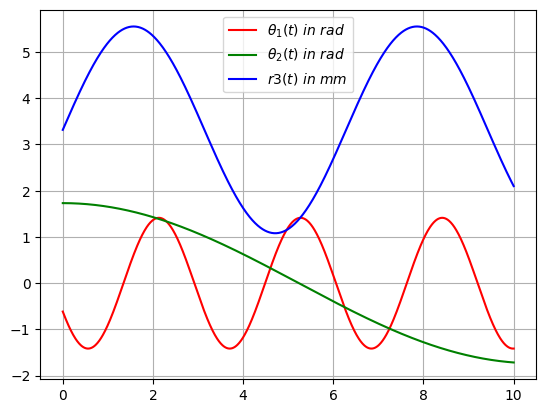

In [25]:
# Position values at time instants
q1_func = sp.lambdify(t, q1_des)
q1_vals = q1_func(t_vals)
q2_func = sp.lambdify(t, q2_des)
q2_vals = q2_func(t_vals)
q3_func = sp.lambdify(t, q3_des)
q3_vals = q3_func(t_vals)

# Velocity values at time instants
dq1_func = sp.lambdify(t, dq1_des)
dq1_vals = dq1_func(t_vals)
dq2_func = sp.lambdify(t, dq2_des)
dq2_vals = dq2_func(t_vals)
dq3_func = sp.lambdify(t, dq3_des)
dq3_vals = dq3_func(t_vals)

# Acceleration values at time instants
ddq1_func = sp.lambdify(t, ddq1_des)
ddq1_vals = ddq1_func(t_vals)
ddq2_func = sp.lambdify(t, ddq2_des)
ddq2_vals = ddq2_func(t_vals)
ddq3_func = sp.lambdify(t, ddq3_des)
ddq3_vals = ddq3_func(t_vals)


fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) # Used to strictly set bounds
ax.grid()
ax.plot(t_vals,q1_vals,'r',label='$\\theta_1(t)~in~rad$')
ax.plot(t_vals,q2_vals,'g',label='$\\theta_2(t)~in~rad$')
ax.plot(t_vals,1000*q3_vals,'b',label='$r3(t)~in~mm$')
ax.legend()

plt.show()

In [27]:
# Generalized forces
tau1_vals = tau1_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals)  # Force values at time instants
tau2_vals = tau2_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals)
f3_vals = f3_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals)

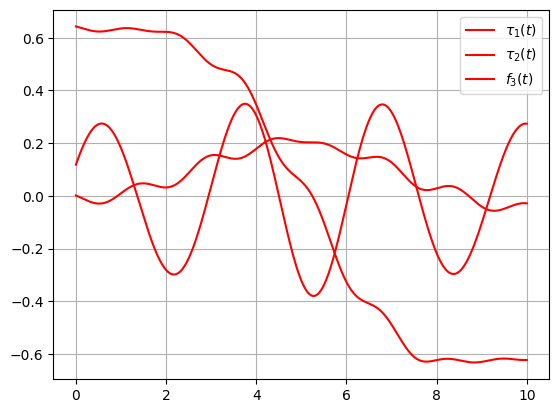

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True)  # Used to strictly set bounds
ax.grid()
ax.plot(t_vals, tau1_vals,'r',label='$\\tau_1(t)$')
ax.plot(t_vals, tau2_vals,'r',label='$\\tau_2(t)$')
ax.plot(t_vals, f3_vals,'r',label='$f_3(t)$')
ax.legend()

plt.show()

### 5. Energy conservation check

In [29]:
# Rewrite energy explicitly as function of time
E = (T+V).subs([(th1, q1), (dth1, dq1), (th2, q2), (dth2, dq2), (r3, q3), (dr3, dq3)])

# Rate of change of total energy written in terms of q, dq, ddq
dE = diff(E, t).subs([(diff(dq1, t), ddq1), (diff(q2, t), dq2), (diff(dq2, t), ddq2), (diff(q3, t), dq3), (diff(dq3, t), ddq3)])
dE

                                                                              
0.629285944905723⋅(q₃(t) - 0.125)⋅dq₂(t)⋅cos(q₂(t)) + 0.0641473949954866⋅ddq₁(

            2       2                                                     2   
t)⋅dq₁(t)⋅q₃ (t)⋅cos (q₂(t)) - 0.0160368487488716⋅ddq₁(t)⋅dq₁(t)⋅q₃(t)⋅cos (q₂

                                                                              
(t)) + 0.0384884369972919⋅ddq₁(t)⋅dq₁(t)⋅q₃(t)⋅cos(q₂(t)) + 0.0045807734287841

                   2                                                          
⋅ddq₁(t)⋅dq₁(t)⋅cos (q₂(t)) + 0.0123656032088407⋅ddq₁(t)⋅dq₁(t)⋅cos(q₂(t)) + 0

                                                                      2       
.050137098773259⋅ddq₁(t)⋅dq₁(t) + 0.0641473949954866⋅ddq₂(t)⋅dq₂(t)⋅q₃ (t) - 0

                                                                              
.0160368487488716⋅ddq₂(t)⋅dq₂(t)⋅q₃(t) + 0.00611848901442022⋅ddq₂(t)⋅dq₂(t) + 

                                              

In [31]:
# Numerical implementation to calculate rate of change of energy as fn of y, vy, ay
dE_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), dE)
dE_vals = dE_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals)

# Power delivered minus energy
power_vals = tau1_vals*dq1_vals +tau2_vals*dq2_vals +f3_vals*dq3_vals - dE_vals

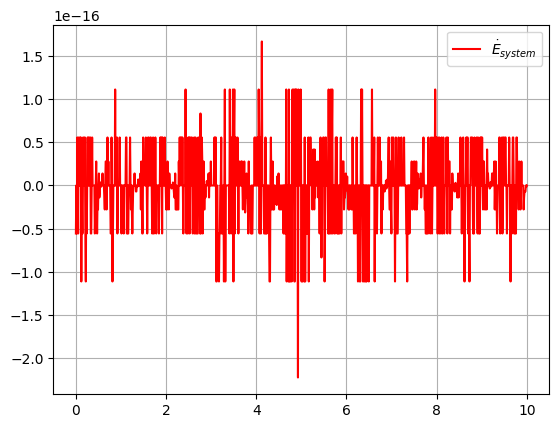

In [32]:
### Energy conservation check

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True)
ax.grid()
ax.plot(t_vals,power_vals,'r',label='$\\dot{E}_{system}$')
ax.legend()

plt.show()